# What do our likelihood surfaces look like?

Bayes:

$$ p(\theta | d) \propto p(d|\theta) \pi(\theta)$$

For a uniform prior, the posterior will look like the likelihood, modulo a normalization factor.

Lets see what some of our univariate likelihood curves look like (i.e. holding all other parameters constant)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

### 1. Example system

In [4]:
import numpy as np 
import logging 

logger = logging.getLogger().setLevel(logging.ERROR)

def iterate_over_iota(phi0_guess,measurement_model,seed):



    #P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5,measurement_model=measurement_model,seed=1237)       #define the system parameters as a class
    P    = SystemParameters(h=1e-12,σp=None,σm=1e-11,measurement_model=measurement_model,seed=seed)       #define the system parameters as a class

    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P) # generate some synthetic data

    #Define the model 
    model = LinearModel(P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,PTA)

    # Run the KFwith the correct parameters
    true_parameters = priors_dict(PTA,P)
  
    true_parameters["phi0_gw"] = phi0_guess

    model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)


    return model_likelihood


#print("Model likelihood is: ", model_likelihood)












In [5]:
x = np.linspace(0.0,0.50,1000) #100 iotas
seeds = np.arange(1237,1238,1) #10 seeds

In [6]:
yc_pulsar = np.zeros((len(x),len(seeds)))
yc_earth = np.zeros((len(x),len(seeds)))
for i in range(len(seeds)):
    for j in range(len(x)):
        yc_pulsar[j,i] = iterate_over_iota(x[j],measurement_model="pulsar",seed = seeds[i])
        yc_earth[j,i] = iterate_over_iota(x[j],measurement_model="earth",seed = seeds[i])


0


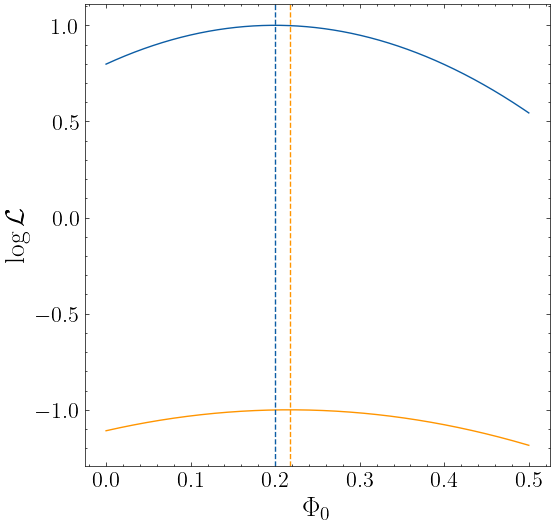

In [7]:
import matplotlib.pyplot as plt 
import scienceplots



plt.style.use('science')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)


for i in range(len(seeds)):
    print(i)
    ypulsar = yc_pulsar[:,i]
    yearth = yc_earth[:,i]

    #Normalise
    ypulsar = ypulsar / np.abs(np.max(ypulsar))
    yearth = yearth / np.abs(np.max(yearth))
    #yearth = yearth + 2.0 



    psr_color = 'C0'
    earth_color = 'C2'
    ax.plot(x,ypulsar,linestyle = 'solid',c=psr_color)
    ax.plot(x,yearth,linestyle = 'solid',c=earth_color)





    idx_psr = np.argmax(ypulsar)
    xc_psr = x[idx_psr]
    ax.axvline(xc_psr,c=psr_color,linestyle='--')


    idx_earth = np.argmax(yearth)
    xc_earth = x[idx_earth]

    #ax.plot([xc_earth,xc_earth],[np.min(yc_earth),np.max(yc_earth)])

    ax.axvline(xc_earth,c=earth_color,linestyle='--')



#plt.axvline(1.0,c='C2',linestyle='--')






fs = 20
ax.set_xlabel(r'$\Phi_0$', fontsize=fs)
ax.set_ylabel(r'$\log \mathcal{L}$', fontsize=fs)

ax.xaxis.set_tick_params(labelsize=fs-4)
ax.yaxis.set_tick_params(labelsize=fs-4)

#ax.yaxis.set_major_locator(plt.MaxNLocator(5))
#plt.setp(ax.get_yticklabels()[0], visible=False)   #no 0th label to prevent overlap  


savefig = 'phi0_likelihood_surface'
plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)





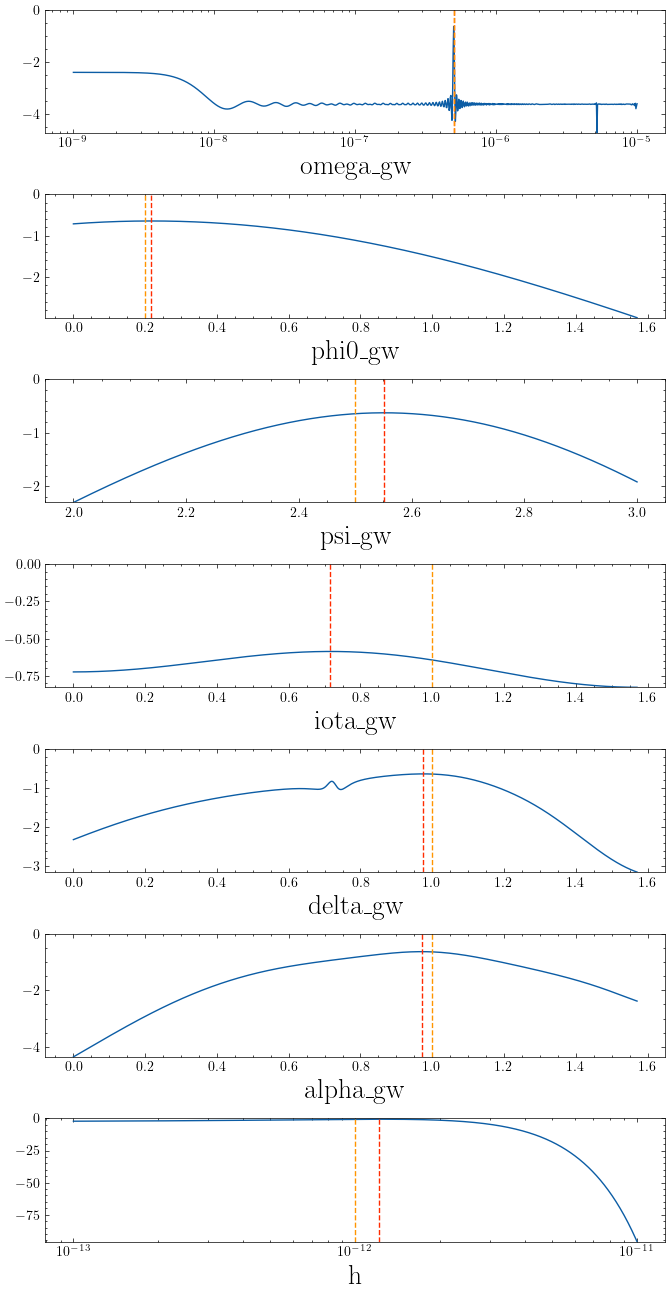

In [ ]:
plot_data_dict(parameters_dict,loaded_data,true_parameters)

In [30]:
variable = 'iota_gw'
variable_range = np.arange(0,np.pi/2.0,0.1)
iota_likelihoods = get_likelihood_instance(P,PTA,data,variable,variable_range)

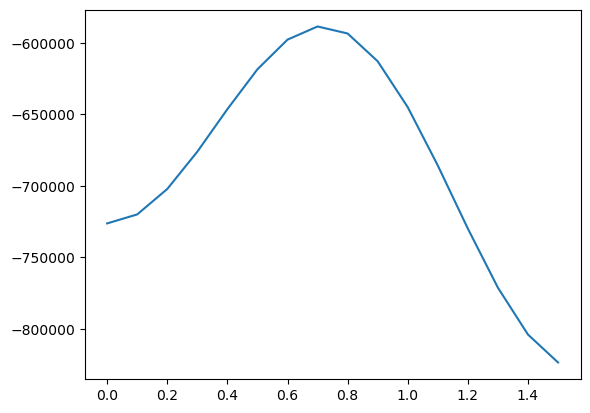

In [31]:
plt.plot(variable_range,iota_likelihoods)

0 omega_gw 5e-07
1 psi_gw 2.5
2 phi0_gw 0.2
3 iota_gw 1.0
4 delta_gw 1.0
5 alpha_gw 1.0
6 h 1e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


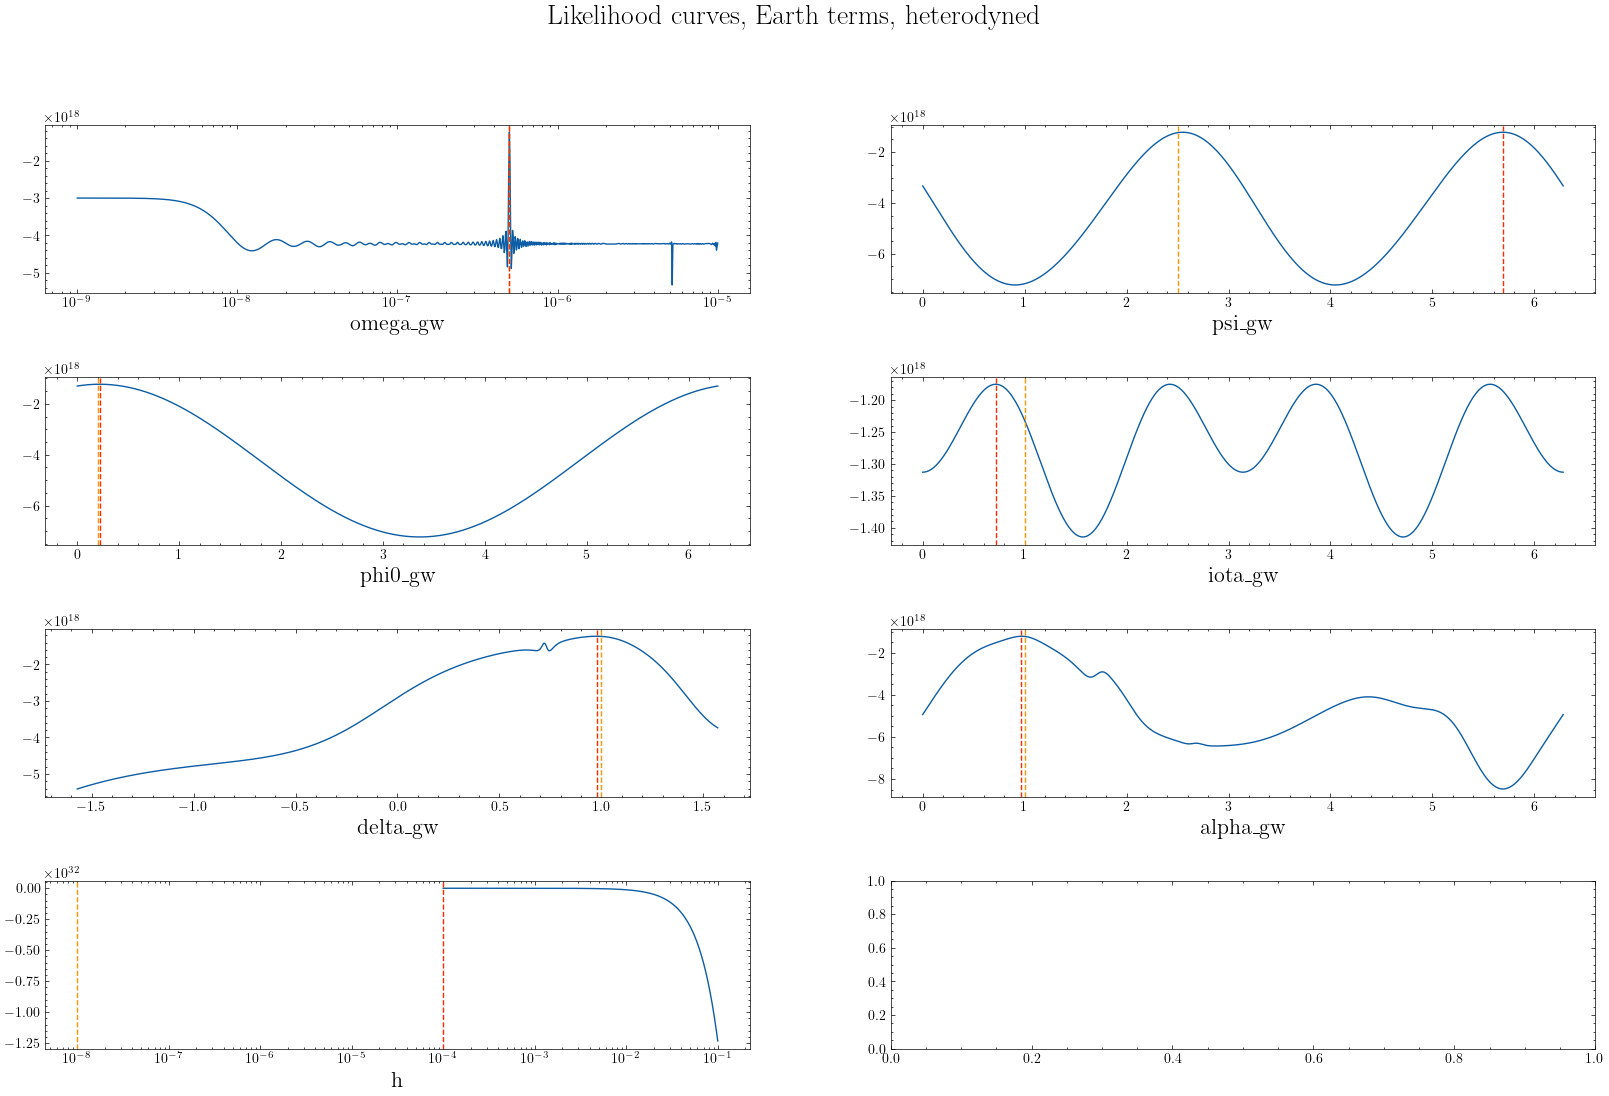

In [13]:
selected_parameters = ["omega_gw",
                    "phi0_gw",
                       "psi_gw",
                        "iota_gw",
                        "delta_gw",
                        "alpha_gw",
                        "h"]
parameters_dict = {k: guessed_parameters[k] for k in selected_parameters}


nsamples = int(1e3)

priors = [np.logspace(-9,-5,nsamples),                   # omega
          np.linspace(0,2*np.pi,nsamples),               # psi
          np.linspace(0,2*np.pi,nsamples),               # phi0
          np.linspace(0,2*np.pi,nsamples),               # iota
          np.linspace(-np.pi/2.0,np.pi/2.0,nsamples),    # delta
          np.linspace(0,2*np.pi,nsamples),               # alpha
          np.logspace(-4,-1,nsamples),                   # h
]

from plotting import likelihoods_over_priors
#likelihoods_over_priors(parameters_dict,priors,PTA,P,KF)
likelihoods_over_priors(parameters_dict,priors,PTA,P,KF,"Likelihood curves, Earth terms, heterodyned", savefig=None)
